# COMP5318 Week 10: Clustering 2: Hierarchical, DBSCAN and Grid-based. Clustering evaluation.  

We will explore three clustering methods: hierrachical aglomerative, DBSCAN and grid-based. We will also learn about clustering evaluation using the Elbow method and the Silhouette coefficient. 

# 1. Setup

In [56]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
TOPIC_ID = "clustering2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    


def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

In [57]:
# Plot functions
        
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)  
    
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)
        

## 2. Agglomerative hierrachical clustering

凝聚的

Hierrachical clustering creates a hierrachy of clusters which can be visialised using a tree-like diagram called dendrogram. There are two approaches: agglomerative and divisive; we will focus on agglomerative which is more common. Agglomerative hierrachical clustering starts with all points as individual clusters and at each step merges the closest pair of clusters iteratively until all points are in the one cluster. 

The distance between clusters can be measured in different ways, e.g. using the single link, complete link, average link or the Ward's method. These methods are implemented in sklearn and specified in the <b>linkage</b> parameter:

- <b>single</b> - merges the two clusters with the smallest <b>minimum</b> distnce between points from the two clusters
- <b>complete</b> - merges the two clusters with the smallest <b>maximum</b> distnce between points from the two clusters
- <b>average</b> - merges the two clusters with the smallest <b>average</b> distance between all their points (all combinations of points between the two clusters)
- <b>ward</b> - merges the two clusters that will result in the smallest <b>increase</b> of variance within all clusters. This is the default option.

Let's generate some 2-dimensional data and apply the agglomerative clustering. There are many possible clusterings corresponding to the different levels of the dendrogram. To obtain a specific clustering, we need to specify the number of clusters, e.g. 3. We can also obtain the cluster label for each example - 0, 1 or 2:

array([2, 1, 1, 1, 1, 2, 0, 0, 1, 0, 0, 2])

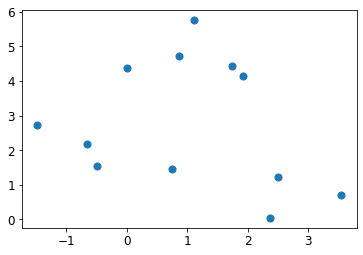

In [58]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering

# Generate some 2-dimensional data 
X, y = make_blobs(random_state=0, n_samples=12)

plt.scatter(X[:,0], X[:,1], s=50)

# Cluster the data using hierarchical agglomerative clustering
# we are looking for 3 clusters, using the default linkage function (linkage="ward")
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X)
agg.labels_

### Drawing a dendrogram

To draw the dendrogram we need to use SciPy, it is not possible to do this with sklearn. We need to redo the clustering using the hierrachical clustering from SciPy which has a slightly different interface:

Text(0, 0.5, 'Cluster distance')

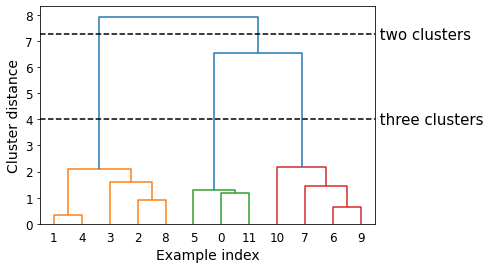

In [59]:
# Import the dendrogram function and the Ward hierrachical clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward


# Apply the Ward hierarchical clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# when performing agglomerative clustering
linkage_array = ward(X)

# linkage_array containing the distances between clusters
# No we can plot the dentrogram using these distances
dendrogram(linkage_array)

# Add labels to the dendrogram and mark the cuts in the dendrogram that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Example index")
plt.ylabel("Cluster distance")

Compare the cluster labels that we obrain from agg.labels_ with the dendrogram and note the correspondence, e.g. points 0, 5 and 11 are in the same cluster (the red one). 

Notice that the length of each dendrogram branch shows how far apart the merged clusters are. Looking at the longest branches, we can see that going from 3 to 2 clusters required merging some very far-apart points.

### Task:

Change the distance measure, e.g. use the complete link. Apply hierrachical clustering and draw the dendrogram. Compare the two dendrograms.

How many clusters are there at distance=1.7?

Text(0, 0.5, 'Cluster distance')

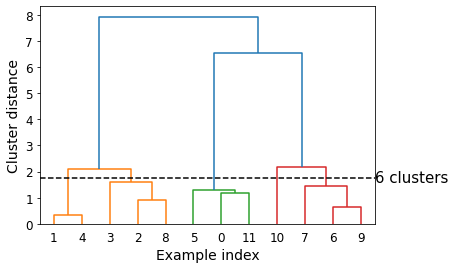

In [60]:
# Import the dendrogram function and the Ward hierrachical clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward


# Apply the Ward hierarchical clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# when performing agglomerative clustering
linkage_array = ward(X)

# linkage_array containing the distances between clusters
# No we can plot the dentrogram using these distances
dendrogram(linkage_array)

# Add labels to the dendrogram and mark the cuts in the dendrogram that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
#ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [1.75, 1.75], '--', c='k')

#ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 1.75, '6 clusters', va='center', fontdict={'size': 15})
plt.xlabel("Example index")
plt.ylabel("Cluster distance")

# 2. DBSCAN

DBSCAN is a density-based clustering algorithm. It defines clusters as continuous regios of high density. It doesn't require the number of clusters to be specified in advance, can capture clusters with complex shapes and can identify points that are not part of any cluster (noise data points).

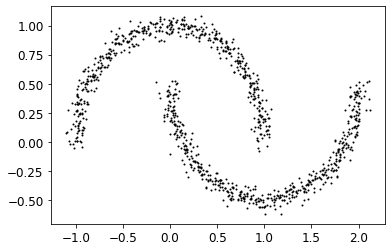

In [61]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
plot_data(X)


#DENSITY 是點跟點之間的半徑

In [62]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The cluster labels of all datapoints are available in the <b>labels_ </b> instance variable. A cluster label of "-1" means a noise data point. Let's look at the cluster label of the first 20 points:

In [63]:
dbscan.labels_[:20]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4])

How many clusters were found?

In [64]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

Now we can take a closer look at the core datapoints. We can find their number and indices, and get the core points themselves:

In [65]:
len(dbscan.core_sample_indices_)


808

In [66]:
dbscan.core_sample_indices_[:20]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21,
       22, 23, 24])

In [67]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

Now let's plot the clustering using the <b>plot_dbscan</b> function defined in the Setup section. The noise points are shown with red crosses and the boundary points are also shown: 

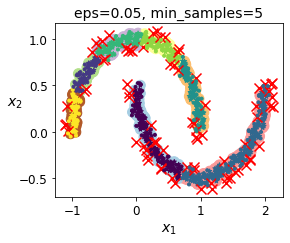

In [68]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.show()

## result is too localize
#eps needs to be increase

How many clusters were found? Seven, plus many noise datapoints. Is this a good clustering?

Let's try different parameters, e.g. increase eps to 0.2 to widen the neighbourhood. We wil plot the two clusterings next to each other:

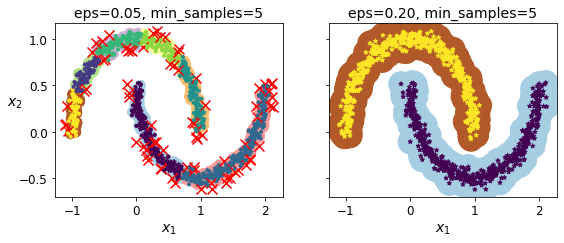

In [69]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

The new clustering is perfect for the moons dataset!


# 3. Grid-based clustering

Grid-based clustering is also an example of density-based clustering as DBSCAN. However, it takes a different approch - it divides the data space into grid cells and then forms clusters from cels that are sufficiently dense. We will consider CLIQUE which is a grid-based subspace method - it looks for clusters in subsets of all dimensions.

Firstly, we need to instal the package for the CLIQUE clustering. Its documentation can be found [here](https://pyclustering.github.io/docs/0.9.3/html/d2/da9/namespacepyclustering_1_1cluster_1_1clique.html#details).

In [70]:
#We'll use the pyclustering package to perform grid-based clustering
#!pip install pyclustering

There are two parameters to choose: 1) <b>intervals</b> - the number of divisions of space in each dimension and 2) density <b>threshold</b> - the minimum number of points that a subspace cell should contain.

In [71]:
from pyclustering.cluster.clique import clique,clique_visualizer

intervals = 15  # number of cels in each dimension 格子會變大
threshold = 4   # min number of datapoints in a cell 一個格子中要多少個點才算，如果太少的話就會變成outlier
# a block that contains <= datapoints will not be considered; its points will be considered as "noise"

# Create a CLIQUE object
clique1 = clique(X, intervals, threshold)

#Clustering
clique1.process()
clusters = clique1.get_clusters()  # clusters found
noise = clique1.get_noise()   # points that are considered as noise (should be 0 in this case)  
cells = clique1.get_cells()   # blocks that form the clustering

We can visualise the clustering results. The first figure shows the grid with the density and the second shows the resulting clustering. 

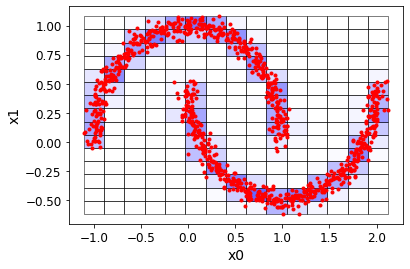

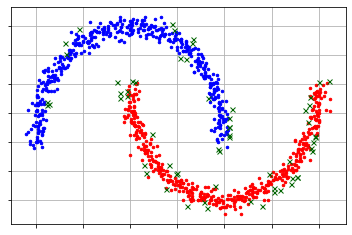

In [72]:
clique_visualizer.show_grid(cells, X)   #show formed grid
clique_visualizer.show_clusters(X, clusters, noise) #show clusters

How many clusters were found? Is this a good clustering?


### Task

Experiment with different parameters - e.g. intervals=15 and threshold=4 and 5. How many clusters were found? Is this a good clustering?

### Task: (to do at home)

Given is synthetic data belonging to five clusters, generated around five centroids as shown below. Use DBSCAN and CLIQUE to cluster the data and plot the resulting clusters.

Were you able to cluster most of the data points back to the five original clusters?


In [73]:
# Synthetic data generation:
blob_centers1 = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.1]])
blob_std1 = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers1,
                  cluster_std=blob_std1, random_state=7)

# 4. Clustering evaluation  

So far we have evaluated the qulaity of the clustering visually. As we know from the lecture, there are measures that we can compute. Today we will see how to use the Elbow method and the Silhouette coefficient to determine the number of clusters and evaluate the qulity of different clusterings. We will use the K-means clustering algorithm. 

Let's create a dataset and do some relevant imports:

In [74]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's perform K-means clustering with 𝑘=3 and 𝑘=8:

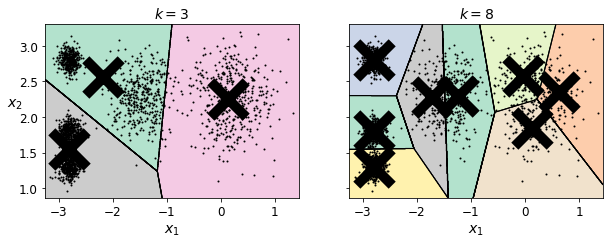

In [75]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

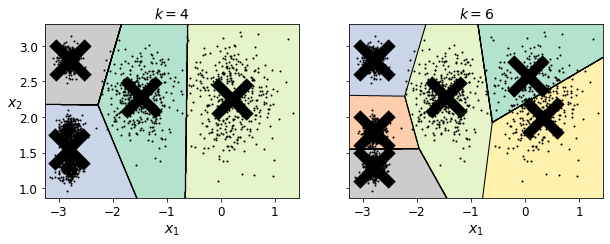

In [76]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42)
kmeans_k6 = KMeans(n_clusters=6, random_state=42)

plot_clusterer_comparison(kmeans_k4, kmeans_k6, X, "$k=4$", "$k=6$")
plt.show()

These two clusterings do not look well! How to find a good number of clusters 𝑘? 

### Elbow method

We can calculate the sum of the squared distances of the examples to their closest cluster centre; it is called <b>inertia</b> in sklearn. For a good clustering, would the inertia be low or high? 

In [77]:
kmeans_k3.inertia_

653.2167190021553

In [78]:
kmeans_k8.inertia_
#也不是數字大就好，因為k多個個點勢必會離自己的cluster最近

119.11983416102879

A low inertia is better - well done! 

However, as we increase 𝑘, the values of the inertia decreases. This is because the more clusters there are, the closer each example will be to its closest centroid, and therefore the lower the inertia will be. 

So we cannot simply choose the 𝑘 which  minimizes the inertia. But we can plot the inertia as a function of 𝑘 and analyze the resulting curve:

In [79]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

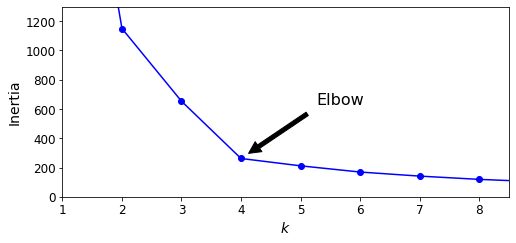

In [80]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

The elbow method is a heuristic method.As you can see, there is an "elbow" at 𝑘=4. After this value, the decrease in inertia is very slow, the curve almost flattens. Hence, having more than 4 clusters will not help much. 

Based on it, we can choose 𝑘=4. For our dataset this means that the two blobs in the lower left part will be considered as a single cluster, so it is not a perfect but still a pretty good choice.


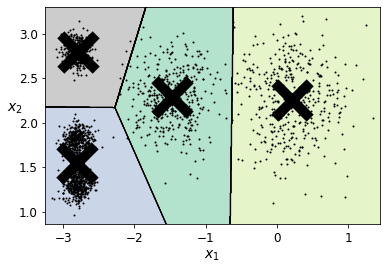

In [81]:
k = 4
plot_decision_boundaries(kmeans_per_k[k-1], X)
plt.show()

### Silhouette coefficient

Another method is to calculate the <b>silhouette score</b>, which is the mean silhouette coefficient over all the examples. An example's silhouette coefficient is equal to (𝑏−𝑎)/max(𝑎,𝑏) where 𝑎 is the mean distance to the other examples in the same cluster (it is the <b>mean intra-cluster distance</b>), and 𝑏 is the <b>mean nearest-cluster distance</b>, that is the mean distance to the examples of the next closest cluster (defined as the one that minimizes 𝑏, excluding the example's own cluster). 


The silhouette coefficient varies between -1 and +1. A value close to +1 means that the example is well inside its own cluster and far from other clusters, a value close to 0 means that it is close to a cluster boundary, and finally a value close to -1 means that the example may have been assigned to the wrong cluster.

To calculate the silhouette score, we can use the silhouette_score() function, giving it all examples in the dataset and the cluster labels they were assigned to:

In [82]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans_k3.labels_)

0.5723900247411775

Let's plot the silhouette score as a function of 𝑘:

Saving figure silhouette_score_vs_k_plot


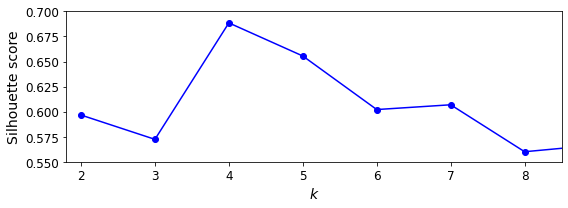

In [83]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one - although it confirms that 𝑘=4 is a very good choice, it also underlines the fact that 𝑘=5 is quite good as well.

An even more informative visualization is given when you plot every example's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a <b>silhouette diagram</b>:


Saving figure silhouette_analysis_plot


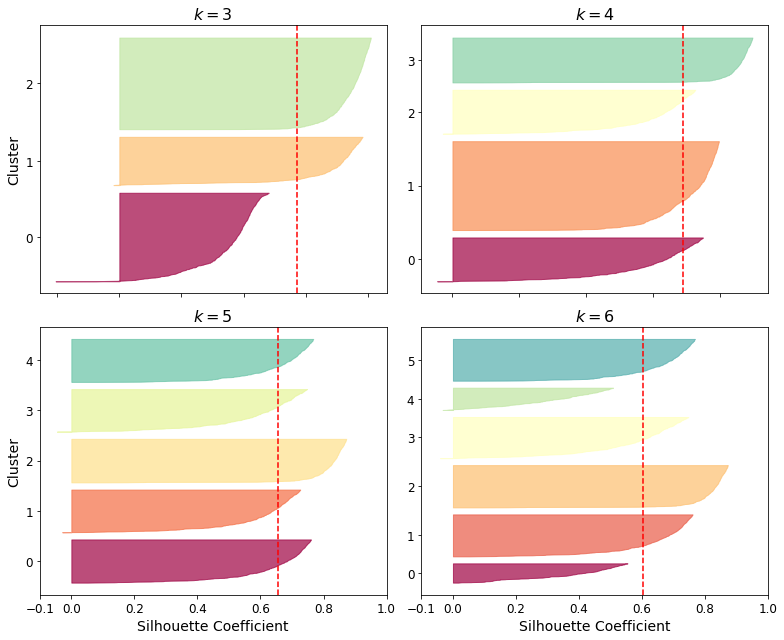

In [84]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()




#先看是不是都超過avg線 在看誰的大小均勻

The red dashed vertical lines represent the silhouette score for each k. 

When most of the examples in a cluster have a lower coefficient than this score (i.e. they are on the left side of the line), then the cluster is bad since this means that its examples are too close to other clusters. We can see that for k = 3 and k = 6, we get bad clusters. But when k = 4 or k = 5, the clusters look pretty good: most examples extend beyond the dashed line, to the right and closer to 1.0. 

Comparing the clusterinngs for k=4 and k=5: 
- When k = 4, the cluster at index 1 (the third from the top) is rather big
- When k = 5, all clusters have similar sizes
- So even though the overall silhouette score for k = 4 is slightly greater than for k = 5, it seems like a good idea to use k = 5 to get clusters of similar sizes

For data with higher dimensionality than 2-3, it is not possible to analyse the silhouette coefficient visually in this way, but we can still calculate its value. 

## Summary

In [86]:
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X)

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

inertias = [model.inertia_ for model in kmeans_per_k]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

### Acknowledgements

This tutorial is based on:

Aurelien Geron (2019). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.

Jake VanderPlas (2016). Python Data Science Handbook, O'Reilly.